# Wasserstein GAN: An Annotated Implementation
*Deep Learning Final Project*

***Authors:***
- *Alberto Mateo*
- *Anna Monso*
- *Judit*
- *Hernan Garcia Quijano*

---

## Introduction: Why Wasserstein?

[cite_start]*Generative Adversarial Networks (GANs) have demonstrated impressive results in unsupervised learning, yet they are notoriously difficult to train*[cite: 34]. [cite_start]*Standard GAN training is "delicate and unstable," often requiring a precise balance between the discriminator and generator to prevent vanishing gradients or mode collapse*[cite: 34, 53].

The paper ***"Wasserstein GAN"*** (Arjovsky et al., 2017) argues that these issues stem from the choice of distance metric used to measure the gap between the real data distribution ($\mathbb{P}_r$) and the model distribution ($\mathbb{P}_\theta$). [cite_start]*Traditional approaches, which often optimize proxies for the Kullback-Leibler (KL) or Jensen-Shannon (JS) divergences, fail when these distributions are supported by low-dimensional manifolds that do not overlap* [cite: 14-17]. [cite_start]*In these disjoint cases, the gradient often vanishes or becomes undefined, halting learning*[cite: 17, 198].

### The Solution: Earth-Mover Distance
The authors propose using the ***Earth-Mover (EM) distance*** (also known as Wasserstein-1). [cite_start]*Intuitively, if we view probability distributions as piles of earth, the EM distance is the minimum cost to transport the mass from one pile to match the other* [cite: 73-74].

[cite_start]*Unlike JS or KL divergences, the EM distance is continuous and differentiable almost everywhere, even when distributions are disjoint* [cite: 81, 112-114]. [cite_start]*This provides smooth, usable gradients for the generator throughout the training process*[cite: 124, 201].

### Key Contributions Annotated in this Project
In this notebook, we implement the ***WGAN*** algorithm to demonstrate its two primary claims:
1.  [cite_start]***A Meaningful Loss Metric:*** *We show that the WGAN critic's loss correlates with sample quality, allowing for easier debugging and hyperparameter search* [cite: 54-55, 235].
2.  [cite_start]***Improved Stability:*** *We demonstrate that WGANs are robust to architectural choices and do not require the delicate balancing of generator and discriminator capacities typical of standard GANs*[cite: 52, 342].

### 1. Setup and Configuration

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Configuration based on WGAN Paper Algorithm 1
config = {
    "learning_rate": 0.00005,      # Paper uses alpha = 0.00005 
    "clip_value": 0.01,            # Clipping parameter c = 0.01 
    "batch_size": 64,              # Batch size m = 64 
    "n_critic": 5,                 # Critic iterations per generator iter = 5 
    "z_dim": 2,                    # Latent dimension (kept small for CPU visualization)
    "input_dim": 2,                # Real data dimension (2D for easy viz)
    "hidden_dim": 64,              # Small capacity for CPU speed
}

### 2. Model Architecture (Analysis & Synthesis)
The paper explicitly validates WGAN using 4-layer ReLU-MLPs with 512 hidden units. For your "Minimal CPU" requirement, we will scale this down to 64 units, but keep the architectural philosophy.


Crucial Annotation Note: You must highlight that the Critic (Discriminator) does not have a sigmoid activation at the end. This is the major architectural difference from a standard GAN.

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Simple MLP Generator
        self.net = nn.Sequential(
            nn.Linear(config["z_dim"], config["hidden_dim"]),
            nn.ReLU(True),
            nn.Linear(config["hidden_dim"], config["hidden_dim"]),
            nn.ReLU(True),
            nn.Linear(config["hidden_dim"], config["input_dim"]),
            # No Sigmoid here because we are generating raw data (R^2 space)
        )

    def forward(self, z):
        return self.net(z)

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        # Simple MLP Critic (formerly Discriminator)
        self.net = nn.Sequential(
            nn.Linear(config["input_dim"], config["hidden_dim"]),
            nn.ReLU(True),
            nn.Linear(config["hidden_dim"], config["hidden_dim"]),
            nn.ReLU(True),
            nn.Linear(config["hidden_dim"], 1) 
            # CRITICAL: No Sigmoid at the output! 
            # The output is a scalar score, not a probability.
        )

    def forward(self, x):
        return self.net(x)

### 3. The WGAN Training Mechanics
This section implements the core mathematical contributions.Weight ClippingTo approximate the Earth Mover distance, the function must be 1-Lipschitz. The paper achieves this by clamping weights to a fixed box $[-\tilde{c}, c]$5.

In [3]:
def clip_weights(model, clip_value):
    """
    Enforce Lipschitz constraint by clipping weights.
    Paper: 'w <- clip(w, -c, c)' [cite: 190]
    """
    for p in model.parameters():
        p.data.clamp_(-clip_value, clip_value)

Initialization 

The paper notes that momentum-based optimizers like Adam can be unstable for the critic because the loss is non-stationary. They suggest RMSProp.

In [5]:
# Initialize models
G = Generator()
C = Critic()

# Use RMSProp as suggested in the paper 
# "We therefore switched to RMSProp which is known to perform well..."
optimizer_G = optim.RMSprop(G.parameters(), lr=config["learning_rate"])
optimizer_C = optim.RMSprop(C.parameters(), lr=config["learning_rate"])

### 4. Minimal CPU-Ready Data (Synthetic)

To satisfy Requirement #4 (MWE), do not use heavy image datasets like LSUN. Instead, replicate Figure 2 or Example 1 from the paper: learning a simple distribution.



Here is a generator for a simple 2D Gaussian Mixture, which trains in seconds on a CPU.

In [6]:
def get_real_data(batch_size):
    """
    Generates a batch of real data: a Gaussian centered at (4, 4).
    This acts as our 'Real Distribution' P_r.
    """
    return torch.randn(batch_size, 2) + 4

### 5. The Training Loop (Annotated)
This strictly follows the loop in Algorithm 1.

Starting training...
Iter 0: Wasserstein Dist Estimate: 0.0000
Iter 200: Wasserstein Dist Estimate: 0.0060
Iter 400: Wasserstein Dist Estimate: 0.0041
Iter 600: Wasserstein Dist Estimate: 0.0021
Iter 800: Wasserstein Dist Estimate: 0.0001
Iter 1000: Wasserstein Dist Estimate: 0.0002
Iter 1200: Wasserstein Dist Estimate: 0.0001
Iter 1400: Wasserstein Dist Estimate: 0.0002
Iter 1600: Wasserstein Dist Estimate: 0.0001
Iter 1800: Wasserstein Dist Estimate: 0.0001


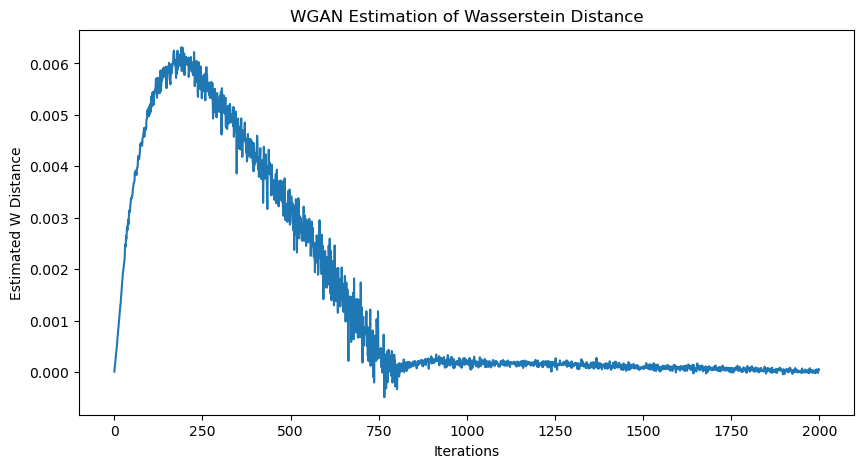

In [7]:
losses_g = []
losses_c = []
w_distances = []

print("Starting training...")

for iteration in range(2000): # Keep iterations low for MWE
    
    # ============================================
    #  1. Train the Critic (n_critic times)
    # ============================================
    for _ in range(config["n_critic"]):
        
        # Sample real data x ~ P_r [cite: 187]
        real_data = get_real_data(config["batch_size"])
        
        # Sample latent z ~ p(z) [cite: 187]
        z = torch.randn(config["batch_size"], config["z_dim"])
        fake_data = G(z).detach() # Detach so we don't backprop to G yet
        
        # Critic Loss: -(Mean(D(real)) - Mean(D(fake)))
        # We want to maximize the gap, so we minimize the negative gap.
        # See Eq (2) and Algorithm 1, Line 5 [cite: 147, 188]
        loss_c = -(torch.mean(C(real_data)) - torch.mean(C(fake_data)))
        
        optimizer_C.zero_grad()
        loss_c.backward()
        optimizer_C.step()
        
        # Clip weights to ensure Lipschitz constraint [cite: 190]
        clip_weights(C, config["clip_value"])
        
    # ============================================
    #  2. Train the Generator (1 time)
    # ============================================
    
    # Sample latent z ~ p(z) [cite: 192]
    z = torch.randn(config["batch_size"], config["z_dim"])
    
    # Generator Loss: -Mean(D(G(z)))
    # The generator wants to maximize the critic's output for its fake data.
    # See Algorithm 1, Line 10 [cite: 192]
    loss_g = -torch.mean(C(G(z)))
    
    optimizer_G.zero_grad()
    loss_g.backward()
    optimizer_G.step()
    
    # Store metrics
    losses_c.append(loss_c.item())
    losses_g.append(loss_g.item())
    # The negative critic loss approximates the Wasserstein distance
    w_distances.append(-loss_c.item())

    if iteration % 200 == 0:
        print(f"Iter {iteration}: Wasserstein Dist Estimate: {-loss_c.item():.4f}")

# Plotting the "Meaningful Loss Metric" [cite: 235]
plt.figure(figsize=(10,5))
plt.title("WGAN Estimation of Wasserstein Distance")
plt.plot(w_distances)
plt.xlabel("Iterations")
plt.ylabel("Estimated W Distance")
plt.show()

### 5. Discussion: Weaknesses/limitations/future directions.